In [2]:
import numpy as np
import sklearn as sk
import pylab as plt
import pandas as pd
import os
import torch
from tqdm.auto import tqdm, trange

from sklearn.ensemble import RandomForestClassifier
from common import gsave, gload
from nde.uci import get_uci_info, load_uci

In [3]:
uci = get_uci_info()

In [4]:
uci[(uci['n'] >= 500) & (uci['num_classes'] >= 2)].sort_values('n')

,name,n,num_classes,num_features
27,cylinder-bands,512,2,35
53,low-res-spect,531,9,100
63,monks-3,554,2,6
61,monks-1,556,2,6
13,breast-cancer-wisc-diag,569,2,30
...,...,...,...,...
19,chess-krvk,28056,18,6
3,adult,48842,2,14
101,statlog-shuttle,58000,7,9
24,connect-4,67557,2,42


In [5]:
def train(x, y):
    clf = RandomForestClassifier(random_state=0, n_estimators=1, bootstrap=False) 
    clf.fit(x, y)
    return clf

def get_acc(name):
    d = load_uci(name) 
    X = d['X']
    y = d['y']
    n = d['n']
    I_tr = d['train_fold']
    I_te = d['test_fold']
    X_tr, y_tr = X[I_tr], y[I_tr]
    X_te, y_te = X[I_te], y[I_te]
    nc = d['num_classes']

    f = train(X_tr, y_tr)
    preds = f.predict(X_te)

    acc = (preds == y_te).mean()
    return acc

def get_aggr(name):
    d = load_uci(name)
    X = d['X']
    y = d['y']
    n = d['n']

    n_tr = int(n*0.4)
    n_te = n - 2*n_tr
    I = np.random.permutation(n)
    I1, I2, I_te = I[range(0, n_tr)], I[range(n_tr, 2*n_tr)], I[range(2*n_tr, n)]
    X_te, y_te = X[I_te], y[I_te]

    f1 = train(X[I1], y[I1])
    f2 = train(X[I2], y[I2])
    preds = [f.predict(X_te) for f in [f1, f2]]
    
    acc1 = (preds[0] == y_te).mean()
    acc2 = (preds[1] == y_te).mean()
    aggr = (preds[0] == preds[1]).mean()
    return acc1, acc2, aggr
        
#get_acc('cylinder-bands')

In [6]:
def compute_all_aggr():
    recs = []
    for name in tqdm(uci['name']):
        d = load_uci(name)
        acc1, acc2, aggr = get_aggr(name)
        n=d['n']
        n_tr = int(n*0.4)
        n_te = n - 2*n_tr
        res = dict(
            name=name,
            n=n,
            n_tr=n_tr,
            n_te=n_te,
            num_classes=d['num_classes'],
            num_features=d['num_features'],
            acc1=acc1,
            acc2=acc2,
            aggr=aggr
                )
        
        recs.append(res)
        
    return pd.DataFrame(recs)

In [7]:
df = compute_all_aggr()
gsave(df, 'gs://ANONYMOUS/tmp/results/uci_df')

In [9]:
dfs = [compute_all_aggr() for _ in trange(100)]
gsave(dfs, 'gs://ANONYMOUS/results/uci/aggr')

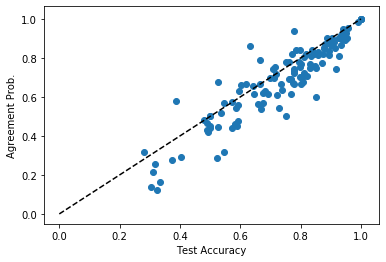

In [8]:
plt.scatter(df['acc1'], df['aggr'])
plt.xlabel('Test Accuracy')
plt.ylabel('Agreement Prob.')
t = np.linspace(0, 1, 10)
plt.plot(t, t, 'k--')

In [30]:
gsave(df, 'gs://ANONYMOUS/tmp/results/uci_df')

In [38]:
print(df.sort_values('acc1').to_string())

                               name       n   n_tr   n_te  num_classes  num_features      acc1      acc2      aggr
41                         heart-va     200     80     40            5            12  0.225000  0.275000  0.300000
84                     plant-margin    1600    640    320          100            64  0.243750  0.243750  0.103125
54                      lung-cancer      32     12      8            3            56  0.250000  0.375000  0.250000
40                heart-switzerland     123     49     25            5            12  0.280000  0.280000  0.200000
85                      plant-shape    1600    640    320          100            64  0.306250  0.240625  0.178125
86                    plant-texture    1599    639    321          100            64  0.355140  0.289720  0.140187
88                    primary-tumor     330    132     66           15            17  0.363636  0.409091  0.227273
6                     audiology-std     196     78     40           18          